# Occurrence Records from GBIF
This notebook is a tool for exploring data sets requested from GBIF (and eventually other sources), and mostly for developing criteria for filtering records (filter sets).  When the entire notebook is run, it retrieves records according to the filter sets specified and saves the results (records and some summary tables) in an sqlite database.  Some information is pulled from the parameters.sqlite database that is saved in this repository.

### Set Variables - fill out stuff in this cell.  
Notes:
default_coordUncertainty -- coordinateUncertaintyInMeters is often not provided.  Here is an option to use a default.  If you don't want anything entered, set this equal to False (boolean, not string).

In [1]:
species_id = 'ahuspx0'
summary_name = 'Hurters Spadefoot'
gbif_req_id = 'EvalGBIFRequest'
gbif_filter_id = 'EvalGBIFFilter'
default_coordUncertainty = False       # Note above.
workDir = 'D:/USGS Analyses/GAP-Habitat-Map-Assessment/'   # Be sure to create folders named "Inputs" and "Outputs" here.
codeDir = workDir + 'Scripts/'
dbDir = workDir + 'db/'
paramdb = dbDir + 'wildlife-wrangler.sqlite'
configDir = workDir  # Path to folder where saved your wildlifeconfig file.

### Setup - nothing to fill out in this cell

In [2]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import numpy as np
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()
import sys
sys.path.append(configDir)
import config
sys.path.append(codeDir)
import repo_functions as functions
inDir = workDir + 'Inputs/'
outDir = workDir + 'Outputs/'
spdb = outDir + species_id + gbif_req_id + gbif_filter_id + '.sqlite'
username = config.gbif_username
password = config.gbif_password
email = config.gbif_email
print("Notebook run " + str(t1))
print(spdb)
connjup = sqlite3.connect(paramdb)
cursorjup = connjup.cursor()
# Get some variables
years = connjup.execute("""SELECT years_range 
                           FROM gbif_requests WHERE request_id = '{0}'""".format(gbif_req_id)).fetchone()[0]
gap_id = connjup.execute("""SELECT gap_id
                            FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]
common_name = connjup.execute("""SELECT common_name
                                 FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]

Notebook run 2020-04-23 09:30:44.043504
D:/USGS Analyses/GAP-Habitat-Map-Assessment/Outputs/ahuspx0EvalGBIFRequestEvalGBIFFilter.sqlite


# Species Concept
Display information on the species from the parameters.sqlite database.

In [3]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
sp_dict = dict(zip(cols, vals))
sp_df = pd.DataFrame.from_dict(sp_dict, orient='index', columns=['VALUE'])
sp_df.index.name = 'ATTRIBUTE'
print("SPECIES CONCEPT RECORD")
print(sp_df)

SPECIES CONCEPT RECORD
                                                   VALUE
ATTRIBUTE                                               
species_id                                       ahuspx0
fws_id                                              None
gap_id                                            aHUSPx
itis_tsn                                          206987
gbif_id                                          2429801
bcb_id                                              None
ebird_id                                            None
common_name                           Hurter's Spadefoot
scientific_name                      Scaphiopus hurterii
start_year                                          1910
split_from                                          None
end_year                                            None
lumped_into                                         None
geometry                                            None
detection_distance_meters                              0
vetted_h

# Filters
Display the parameters of the request filter set.  These are deployed during the step where records are retrieved from the API.

In [4]:
request_df = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id), con=connjup)
print("THE REQUEST FILTER SET")
print(request_df.loc[0])

THE REQUEST FILTER SET
request_id                    EvalGBIFRequest
source                                   GBIF
lat_range                                None
lon_range                                None
years_range                         1999,2020
months_range                             1,12
geoissue                                False
coordinate                               True
country                                    US
geometry                                 None
creator                             M. Rubino
notes           amphibian evaluation reque...
Name: 0, dtype: object


Display the parameters of the post-request filter set.  These are deployed after the records are retrieved from the API, but before they are stored in the occurrence record sqlite database.

In [5]:
filter_df = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(gbif_filter_id), con=connjup)
print("THE POST REQUEST FILTER SET")
print(filter_df.loc[0])

THE POST REQUEST FILTER SET
filter_id                                    EvalGBIFFilter
dataset                                                GBIF
institutions_omit                                      None
collection_codes_omit                                  None
datasets_omit                                          None
has_coordinate_uncertainty                                1
max_coordinate_uncertainty                            10000
bases_omit                                  FOSSIL_SPECIMEN
sampling_protocols_omit                                None
issues_omit                                            None
duplicates_OK                                         False
creator                                           M. Rubino
notes                         amphibian evaluation filte...
Name: 0, dtype: object


In [6]:
functions.retrieve_gbif_occurrences(codeDir, species_id, inDir, paramdb, spdb, gbif_req_id, gbif_filter_id, 
                                    default_coordUncertainty, outDir, summary_name, username,
                                   password, email)

SPATIALITE_SECURITY set to relaxed
Created occurrence db: 0:00:00.231203
Got request params and sorted out geometry constraints: 0:00:00.001001
294 records available
Downloaded records: 0:00:03.017908
Summarized fields returned: 0:00:16.435715
Created summary table of request results: 0:00:00.033273
Performed post-request filtering: 0:00:00.015013
Calculated new columns, deleted some too: 0:00:00.037031
3 duplicate records dropped: 0:00:00.222185
Inserted records into table: 0:00:00.033034
Summarized unique values retained: 0:00:00.001996
Updated occurrences table geometry column: 0:00:00.021017
Buffered points: 0:00:00.311271


In [7]:
print('codeDir: '+codeDir+'\n', 
'species_id: '+species_id+'\n', 
'inDir: '+inDir+'\n', 
'paramdb: '+paramdb+'\n', 
'spdb: '+spdb+'\n', 
'gbif_req_id: '+gbif_req_id+'\n', 
'gbif_filter_id: '+gbif_filter_id+'\n', 
'default_coordUncertainty: '+str(default_coordUncertainty)+'\n', 
'outDir: '+outDir+'\n', 
'summary_name: '+summary_name+'\n', 
'username: '+username+'\n',
'password: '+password+'\n', 
'email: '+email)

codeDir: D:/USGS Analyses/GAP-Habitat-Map-Assessment/Scripts/
 species_id: ahuspx0
 inDir: D:/USGS Analyses/GAP-Habitat-Map-Assessment/Inputs/
 paramdb: D:/USGS Analyses/GAP-Habitat-Map-Assessment/db/wildlife-wrangler.sqlite
 spdb: D:/USGS Analyses/GAP-Habitat-Map-Assessment/Outputs/ahuspx0EvalGBIFRequestEvalGBIFFilter.sqlite
 gbif_req_id: EvalGBIFRequest
 gbif_filter_id: EvalGBIFFilter
 default_coordUncertainty: False
 outDir: D:/USGS Analyses/GAP-Habitat-Map-Assessment/Outputs/
 summary_name: Hurters Spadefoot
 username: gapper
 password: metspirates
 email: pythonprocessing@gmail.com


### Connect to output database, record species and filter info.

In [8]:
conn_occ= sqlite3.connect(spdb)
curs_occ = conn_occ.cursor()
sp_df.to_sql(name='species_concept', con=conn_occ, if_exists='replace')
request_df.to_sql(name=gbif_req_id, con=conn_occ, if_exists='replace')
filter_df.to_sql(name=gbif_filter_id, con=conn_occ, if_exists='replace')

### How many records made it through the filters?
This is the number that was actually saved in the occurrence record sqlite database.

In [9]:
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records")

138 records


# Sources
#### Pre-filters

In [10]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [gbif_req_id, gbif_filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

sources = pd.read_sql(sql="SELECT * FROM pre_filter_source_counts;", con=conn_occ)
print(sources)

GBIF
  institutionCode collectionCode                    datasetName    0
0            FHSM           HERP                        UNKNOWN    1
1             MCZ           Herp                        UNKNOWN    2
2            OMNH     Amphibians                        UNKNOWN   19
3            OMNH           OCGR  Oklahoma Collection of Gen...   15
4            TCWC    Herpetology                        UNKNOWN   49
5             YPM             VZ                        UNKNOWN    1
6     iNaturalist   Observations  iNaturalist research-grade...  207


#### Post-filters

In [11]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [gbif_req_id, gbif_filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

sql = "SELECT institutionCode, collectionCode, datasetName, COUNT(occ_id) FROM occurrences GROUP BY institutionCode, collectionCode, datasetName;"
sources = pd.read_sql(sql=sql, con=conn_occ)
print(sources)

GBIF
  institutionCode collectionCode                    datasetName  COUNT(occ_id)
0             MCZ           Herp                        UNKNOWN              2
1            OMNH     Amphibians                        UNKNOWN              1
2             YPM             VZ                        UNKNOWN              1
3     iNaturalist   Observations  iNaturalist research-grade...            134


# Bases
#### Pre-filter

In [12]:
bases = pd.read_sql(sql="SELECT value as basisOfRecord, count FROM pre_filter_value_counts WHERE attribute = 'bases';", con=conn_occ)
print(bases)

        basisOfRecord  count
0   HUMAN_OBSERVATION    207
1  PRESERVED_SPECIMEN     87


#### Post-filters

In [13]:
sql = "SELECT basisOfRecord, COUNT(occ_id) as count FROM occurrences GROUP BY basisOfRecord;"
bases = pd.read_sql(sql=sql, con=conn_occ)
print(bases)

        basisOfRecord  count
0   HUMAN_OBSERVATION    134
1  PRESERVED_SPECIMEN      4


# Protocols
#### Pre-filters

In [14]:
protocol = pd.read_sql(sql="SELECT value as samplingProtocol, count FROM pre_filter_value_counts WHERE attribute = 'samplingProtocols';", con=conn_occ)
print(protocol)

  samplingProtocol  count
0          UNKNOWN    294


#### Post-filters

In [15]:
sql = "SELECT samplingProtocol, COUNT(occ_id) as count FROM occurrences GROUP BY samplingProtocol;"
print(pd.read_sql(sql=sql, con=conn_occ))

  samplingProtocol  count
0          UNKNOWN    138


# Issues
#### Pre-filters

In [16]:
iss = pd.read_sql(sql="SELECT value as issues, count FROM pre_filter_value_counts WHERE attribute = 'issues';", con=conn_occ)
pd.set_option('display.max_colwidth', 80)
print(iss)

                                                           issues  count
0                ['COORDINATE_ROUNDED', 'COORDINATE_REPROJECTED']      1
1          ['COORDINATE_ROUNDED', 'GEODETIC_DATUM_ASSUMED_WGS84']    150
2                     ['COORDINATE_ROUNDED', 'TAXON_MATCH_FUZZY']     14
3                                          ['COORDINATE_ROUNDED']      5
4  ['GEODETIC_DATUM_ASSUMED_WGS84', 'PRESUMED_NEGATED_LONGITUDE']      3
5           ['GEODETIC_DATUM_ASSUMED_WGS84', 'TAXON_MATCH_FUZZY']      3
6                                ['GEODETIC_DATUM_ASSUMED_WGS84']     77
7                                           ['TAXON_MATCH_FUZZY']     35
8                                                              []      6


#### Post-filters

In [17]:
sql = "SELECT issues, COUNT(occ_id) as count FROM occurrences GROUP BY issues;"
print(pd.read_sql(sql=sql, con=conn_occ))

                                            issues  count
0                                                       1
1                               COORDINATE_ROUNDED      2
2        COORDINATE_ROUNDED;COORDINATE_REPROJECTED      1
3  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84     97
4                     GEODETIC_DATUM_ASSUMED_WGS84     37


# Descriptions of filtered records

### Years represented

Text(0.5, 1.0, 'Occurrences per Year')

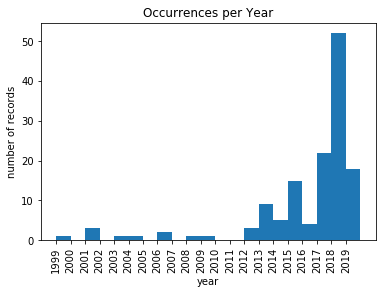

In [18]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
years = connjup.execute("SELECT years_range FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id)).fetchone()[0]
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of records")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

### Months represented

Text(0.5, 1.0, 'Occurrences per Month')

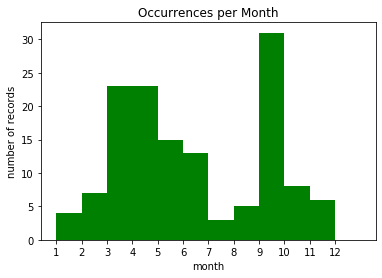

In [19]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of records")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### Distribution of coordinate uncertainty values

Text(0.5, 1.0, 'Coordinate Uncertainty')

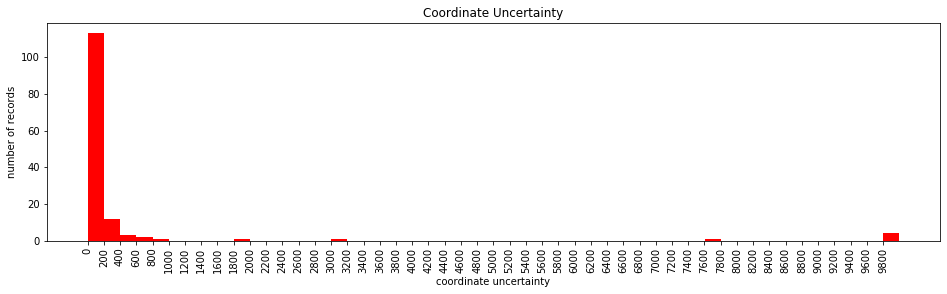

In [20]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty - Zoomed In')

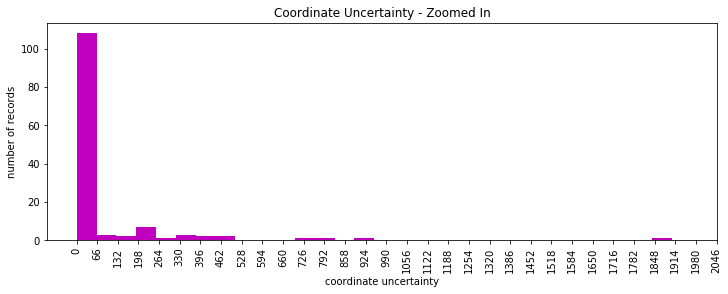

In [21]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty - Zoomed In")

### Establishment means reported

In [22]:
establishment = curs_occ.execute("SELECT vals FROM unique_values WHERE field = 'establishment' AND step = 'filter';").fetchall()[0]
for est in establishment:
    est = est.replace('[', '').strip().replace(']', '').replace("'", "")
    print(est)

UNKNOWN


### Identification qualifiers included

In [23]:
quali = curs_occ.execute("SELECT DISTINCT vals FROM unique_values WHERE field = 'IDqualifier' AND step = 'filter';").fetchall()[0]
for q in quali:
    q = q.replace('[', '').strip().replace(']', '').replace("'", "")
    print(q)

UNKNOWN


### Remarks included

In [24]:
remarks = curs_occ.execute("SELECT DISTINCT remarks FROM occurrences;").fetchall()
if len(remarks) <= 20:
    try:
        for rem in remarks:
            if rem[0][0:1] == ';':
                print(rem[0][2:])
            else:
                print(rem[0])
    except:
        pass
else:
    print("More than 20 remarks, consult the occurrence database.")

More than 20 remarks, consult the occurrence database.


### Attributes returned for the records in the request (pre-filters)

In [25]:
fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", conn_occ)#, index_col='index')
fields_summary.index.name = 'Field'
pd.set_option('display.max_rows', 250)
print(fields_summary)

                                  attribute  included(n)  populated(n)
Field                                                                 
0                    acceptedScientificName          294           294
1                          acceptedTaxonKey          294           294
2                              accessRights           51            51
3                      associatedReferences           16            16
4                       associatedSequences           17            17
5                             basisOfRecord          294           294
6                     bibliographicCitation           50            50
7                             catalogNumber          294           294
8                                     class          294           294
9                                  classKey          294           294
10                           collectionCode          294           294
11                             collectionID           68            68
12    

### Runtime

In [26]:
t2 = datetime.now()
print(t2 - t1)

0:00:23.480351
